# Fireveg DB - export data to RDS format

By: [José R. Ferrer-Paris](https://github.com/jrfep)

Date: Thu 22 Aug 2024

This Jupyter Notebook includes R code to query data from the Fireveg Database and download data in different dataframes for further analysis and visualisation.

The output of this notebook is saved in RDS and GPKG formats in a local folder. Then we run another noteboook to [upload files to OSF](./Upload-files-to-OSF.ipynb).

**Please note:**
<div class="alert alert-warning">
    This code is intended for internal project management and  is documented for the sake of reproducibility.<br/>
    🛂 Only users contributing directly to the project have access to the credentials for data download/upload. 
</div>

## Set-up

### Packages
We are using R for this. Start your session and load the packages.

For the newer version of the database we are using package `Rpostgres` to ensure [a secure connection](https://stackoverflow.com/questions/30989264/connect-to-postgres-via-ssl-using-r).

In [1]:
#library(RPostgreSQL)
library(RPostgres)
library(dplyr)
library(tidyr)
library(lubridate)
library(ggplot2)
library(sf)

Warning message:
“package ‘RPostgres’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



### Working directory and relative paths
Using the functions from `here` package to find the root of the project directory.

In [2]:
here::i_am("RDS-output/Read-tables-from-database.ipynb")

here() starts at /Users/z3529065/proyectos/fireveg/fireveg-db-exports



### Data folder
We will use a local folder to store all the output files in CSV or RDS format. Let's create this folder relative to the project root.

In [3]:
data_dir <- here::here("data", "output-Rdata")
if (!dir.exists(data_dir))
    dir.create(data_dir)

🐘 The data folder is checked in our `.gitignore` so that its contents are not tracked by git. We use this folder locally, and then upload the files to a cloud drive for project-wide sharing. Check here how to [Upload files to OSF](./Upload-files-to-OSF.ipynb).

### Database credentials

🤫 We use a folder named "secrets" to keep the credentials for connection to different services (database credentials, API keys, etc). This checked this folder in our `.gitignore` so that its content are not tracked by git and not exposed. Future users need to copy the contents of this folder manually.

We will use `readRenviron` function to (re-)load the `.Renviron.local` file in our `secrets` folder.

In [4]:
readRenviron(here::here("secrets","Renviron.local"))

## Query database

### Connect to the database

We will use the credentials loaded from the `.Renviron` file to connect to the postgresql server. (Password is stored in a `.pgpass` file in the user directory).

In [5]:
drv <- Postgres() ## 
con <- dbConnect(drv, 
                 dbname = Sys.getenv("DBNAME"),
                 host = Sys.getenv("DBHOST"), 
                 port = Sys.getenv("DBPORT"),
                 user = Sys.getenv("DBUSER"),
                sslmode = 'require')

### Query for field data

We create a query joining data from different tables.

In [6]:
qry <- 
'WITH FH AS (
    SELECT visit_id, visit_date, MAX(earliest_date) as min_fire_date, 
        MAX(latest_date) as max_fire_date
    FROM form.field_visit
    LEFT JOIN form.fire_history
        ON visit_id=site_label
    GROUP BY visit_id, visit_date)
SELECT visit_id, visit_date, sample_nr,
    sample_method, quadrat_area,
    min_fire_date, max_fire_date,
    species, species_code,
    resprout_organ, seedbank,
    adults_unburnt,
    resprouts_live, resprouts_died, resprouts_kill, 
        resprouts_reproductive,
    recruits_live, recruits_died, recruits_reproductive,
    scorch, life_stage
FROM form.quadrat_samples
LEFT JOIN form.field_samples 
    USING (visit_id,visit_date,sample_nr)
LEFT JOIN FH
    USING (visit_id,visit_date)
'

Execute the query

In [7]:
quadrat.samples <- dbGetQuery(con, qry)

Check the data frame:

In [8]:
head(quadrat.samples)

,visit_id,visit_date,sample_nr,sample_method,quadrat_area,min_fire_date,max_fire_date,species,species_code,resprout_organ,⋯,adults_unburnt,resprouts_live,resprouts_died,resprouts_kill,resprouts_reproductive,recruits_live,recruits_died,recruits_reproductive,scorch,life_stage
,<chr>,<date>,<int>,<chr>,<dbl>,<date>,<date>,<chr>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,CRC09B7UVH,2021-02-03,1,NA,NA,2021-02-03,2021-02-03,Goodenia ovata,3192,NA,⋯,0,0,NA,NA,0,100,NA,0,NA,NA
2,CRC09B7UVH,2021-02-03,1,NA,NA,2021-02-03,2021-02-03,Gonocarpus tetragynus,3247,NA,⋯,0,100,NA,NA,0,0,NA,0,NA,NA
3,CRC09B7UVH,2021-02-03,1,NA,NA,2021-02-03,2021-02-03,Eucalyptus blaxlandii,4058,NA,⋯,0,0,NA,NA,0,16,NA,0,NA,NA
4,CRC09B7UVH,2021-02-03,1,NA,NA,2021-02-03,2021-02-03,Eucalyptus viminalis,4197,NA,⋯,0,0,NA,NA,0,1,NA,0,NA,NA
5,CRC09B7UVH,2021-02-03,1,NA,NA,2021-02-03,2021-02-03,Pteridium esculentum,6403,NA,⋯,0,32,NA,NA,0,0,NA,0,NA,NA
6,CRC09B7UVH,2021-02-03,1,NA,NA,2021-02-03,2021-02-03,Opercularia aspera,5697,None,⋯,0,0,NA,NA,0,4,NA,0,NA,NA


Summary of the data considering samples before and after 2018

In [9]:
quadrat.samples |> 
    group_by(sample_year=year(visit_date) >2018) |>
    summarise(
        locations = n_distinct(visit_id),
        visits  = n_distinct(visit_id, visit_date),
              samples  = n_distinct(visit_id, visit_date, sample_nr),
              records = n(), 
              species = n_distinct(species), 
              codes = n_distinct(species_code)) |> 
    arrange(sample_year)

sample_year,locations,visits,samples,records,species,codes
<lgl>,<int>,<int>,<int>,<int>,<int>,<int>
FALSE,61,85,510,8588,181,149
TRUE,85,85,714,9809,878,825


We save the downloaded data to a RDS file. This will be later uploaded to OSF cloud storage, this file will not be tracked by git.

### Query fire history
For the fire history we create and execute two queries:

In [10]:
qry <- 
'SELECT visit_id as site_label, visit_date
FROM form.field_visit'
site.visits <- dbGetQuery(con, qry)

In [11]:
qry <- 
'SELECT site_label, earliest_date,latest_date, how_inferred, cause_of_ignition
FROM form.fire_history'
fire.history <- dbGetQuery(con, qry)

We visualise the data in a plot

Warning message:
“Removed 33 rows containing missing values or values outside the scale range (`geom_point()`).”


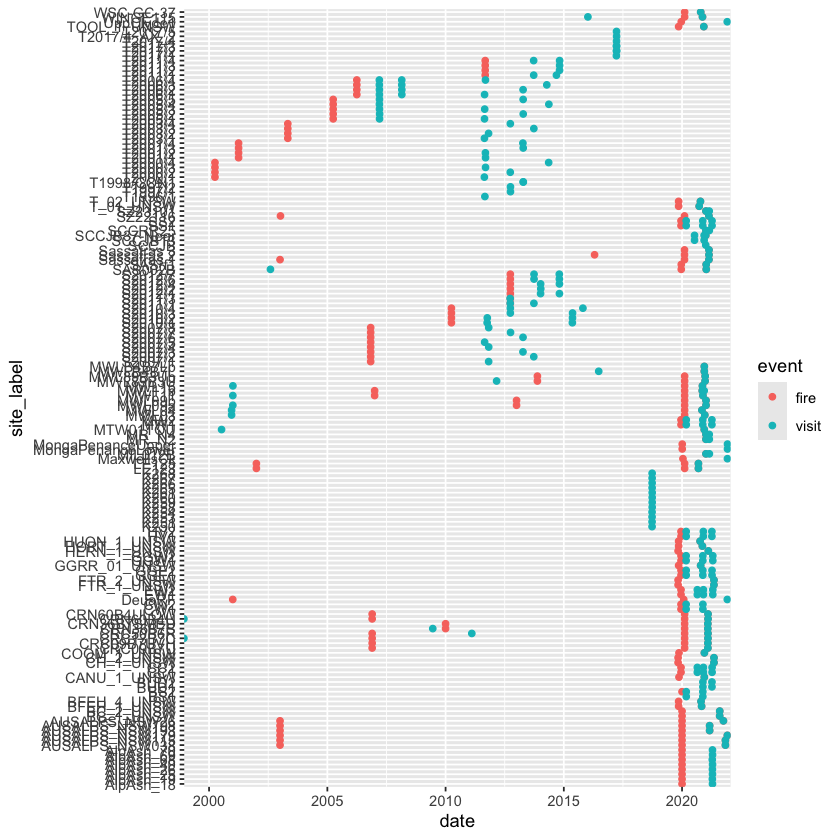

In [12]:
dts <- fire.history |> 
    transmute(site_label,date=earliest_date,event='fire') |> 
    bind_rows(site.visits |> 
                  transmute(site_label,date=visit_date,event='visit'))

ggplot(dts) + 
    geom_point(aes(x=date,y=site_label,colour=event)) +
    coord_cartesian(xlim=as.Date(c('2000-01-01','2021-01-01')))

### Query site spatial data
We create a query to the database to retrieve the site locations as points. We use the function `read_sf` to read the query as a simple feature object. 

In [13]:
qry <- 
'SELECT DISTINCT site_label, location_description, elevation, 
    ST_Transform(geom,4326) as geom, 
    survey_name, survey_description
FROM form.field_visit 
LEFT JOIN form.field_site 
    ON visit_id=site_label
LEFT JOIN form.surveys 
    USING (survey_name)'
site_locs <- read_sf(con, query=qry)

We take a glimpse at the data:

In [14]:
glimpse(site_locs)

Rows: 163
Columns: 6
$ site_label           <chr> "AlpAsh_18", "AlpAsh_19", "AlpAsh_25", "AlpAsh_26…
$ location_description <chr> "Near top of rise 110m SSW of junction of Link Rd…
$ elevation            <dbl> 1325, 1395, 1365, 1400, 1105, 1350, 1450, 1410, 1…
$ survey_name          <chr> "KNP AlpAsh", "KNP AlpAsh", "KNP AlpAsh", "KNP Al…
$ survey_description   <chr> "Kosciuszko NP Alpine Ash", "Kosciuszko NP Alpine…
$ geom                 <POINT [°]> POINT (148.3823 -35.90624), POINT (148.3301…


And plot their spatial locations:

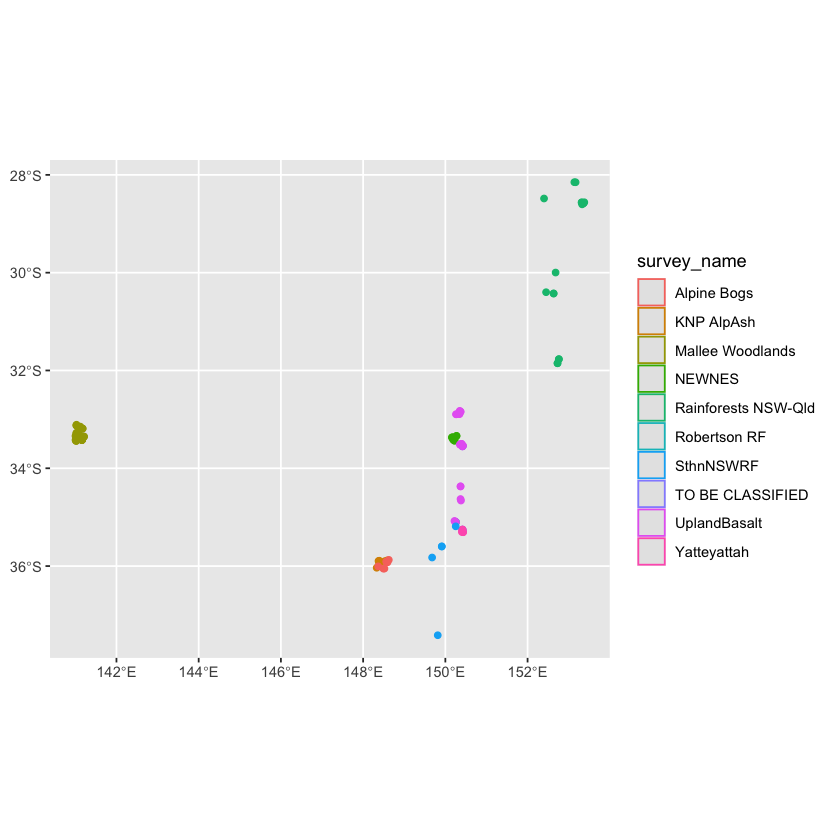

In [15]:
ggplot(site_locs) + 
    geom_sf(aes(colour=survey_name)) 

### Query traits information
We will take a look at the trait description stored in the `trait_info` table of the database.

In [16]:
qry <- "SELECT code, name, description, life_stage, life_history_process, priority
FROM litrev.trait_info"
trait_info <- dbGetQuery(con, qry)

This is a very simple table:

In [17]:
filter(trait_info, !is.na(priority)) %>% 
    select(code,name,life_stage,life_history_process) %>%
    arrange(code)

code,name,life_stage,life_history_process
<chr>,<chr>,<chr>,<chr>
disp1,Propagule dispersal mode,Seed,Dispersal
germ1,Seedbank Type,Seed,Germination
germ8,Seed dormancy type,Seed,Germination
grow1,Age to develop regenerative/resistance organs,Standing plant,Growth
rect2,Establishment pattern,Seedling,Recruitment
repr2,Post-fire flowering response,Standing plant,Reproduction
repr3,Age at first flower production (from seed),Standing plant,Reproduction
repr3a,Time to first postfire reproduction (from resprouts),Standing plant,Reproduction
repr4,Maturation age,Standing plant,Reproduction


### Query combining all traits

We use here a template query to retrieve the common metadata of each record (not including values).


In [18]:
qry <- 
"SELECT family, genus, \"speciesID\" as spp, 
\"scientificName\" as species,
'%1$s' as traitcode,
trait.record_id as rid,
main_source,
unnest(original_sources) as primary_source
FROM species.bionet  
LEFT JOIN litrev.%1$s trait
    ON \"speciesCode_Synonym\"=trait.species_code::text;
"

We now run the queries substituting the trait codes into the query template

In [19]:
traits_table <- tibble()
priority_traits <- c("surv1", "surv4", "surv5", "surv6", "surv7",
                    "disp1",
                    "germ1", "germ8",
                    "grow1",
                    "repr2", "repr3", "repr3a", "repr4",
                    "rect2"
                    )
for (traitcode in priority_traits) {
    traits_table <- traits_table %>% 
    bind_rows(dbGetQuery(con, sprintf(qry,traitcode)))
}

Check the total numbers of records 

In [20]:
traits_table %>% 
    summarise(
        total=n(), 
        records=n_distinct(rid), 
        main_sources=n_distinct(main_source), 
        sources=n_distinct(primary_source))

total,records,main_sources,sources
<int>,<int>,<int>,<int>
59171,55118,2,357


In [21]:
head(traits_table)

family,genus,spp,species,traitcode,rid,main_source,primary_source
<chr>,<chr>,<int64>,<chr>,<chr>,<int>,<chr>,<chr>
Poaceae,Anisopogon,10400,Anisopogon avenaceus,surv1,143210,austraits-6.0.0,Auld Keith Bradstock 2000
Rutaceae,Asterolasia,11411,Asterolasia elegans,surv1,143211,austraits-6.0.0,Auld Keith Bradstock 2000
Polygalaceae,Comesperma,2384,Comesperma ericinum,surv1,143212,austraits-6.0.0,Auld Keith Bradstock 2000
Proteaceae,Conospermum,9862,Conospermum taxifolium,surv1,143213,austraits-6.0.0,Auld Keith Bradstock 2000
Myrtaceae,Darwinia,11995,Darwinia biflora,surv1,143214,austraits-6.0.0,Auld Keith Bradstock 2000
Myrtaceae,Darwinia,11995,Darwinia biflora,surv1,143215,austraits-6.0.0,Auld Keith Bradstock 2000


### Query traits per family

We first create a temporary table with the union of all trait tables.

In [22]:
qry <- 
"CREATE TEMP TABLE species_traits (species_code,trait_codes) AS (
  WITH A AS (
    SELECT 'repr2' AS table_name, species_code FROM litrev.repr2
    UNION SELECT 'germ8' AS table_name, species_code FROM litrev.germ8
    UNION SELECT 'rect2' AS table_name, species_code FROM litrev.rect2
    UNION SELECT 'germ1' AS table_name, species_code FROM litrev.germ1
    UNION SELECT 'grow1' AS table_name, species_code FROM litrev.grow1
    UNION SELECT 'repr4' AS table_name, species_code FROM litrev.repr4
    UNION SELECT 'surv5' AS table_name, species_code FROM litrev.surv5
    UNION SELECT 'surv6' AS table_name, species_code FROM litrev.surv6
    UNION SELECT 'surv7' AS table_name, species_code FROM litrev.surv7
    UNION SELECT 'disp1' AS table_name, species_code FROM litrev.disp1
    UNION SELECT 'repr3' AS table_name, species_code FROM litrev.repr3a
    UNION SELECT 'repr3a' AS table_name, species_code FROM litrev.repr3
    UNION SELECT 'surv4' AS table_name, species_code FROM litrev.surv4
    UNION SELECT 'surv1' AS table_name, species_code FROM litrev.surv1
  )
  SELECT species_code,array_agg(table_name) FROM A GROUP BY species_code
);"

In [23]:
dbSendQuery(con, qry)

<PqResult>
  SQL  CREATE TEMP TABLE species_traits (species_code,trait_codes) AS (
  WITH A AS (
    SELECT 'repr2' AS table_name, species_code FROM litrev.repr2
    UNION SELECT 'germ8' AS table_name, species_code FROM litrev.germ8
    UNION SELECT 'rect2' AS table_name, species_code FROM litrev.rect2
    UNION SELECT 'germ1' AS table_name, species_code FROM litrev.germ1
    UNION SELECT 'grow1' AS table_name, species_code FROM litrev.grow1
    UNION SELECT 'repr4' AS table_name, species_code FROM litrev.repr4
    UNION SELECT 'surv5' AS table_name, species_code FROM litrev.surv5
    UNION SELECT 'surv6' AS table_name, species_code FROM litrev.surv6
    UNION SELECT 'surv7' AS table_name, species_code FROM litrev.surv7
    UNION SELECT 'disp1' AS table_name, species_code FROM litrev.disp1
    UNION SELECT 'repr3' AS table_name, species_code FROM litrev.repr3a
    UNION SELECT 'repr3a' AS table_name, species_code FROM litrev.repr3
    UNION SELECT 'surv4' AS table_name, species_code FR

Now we query which species have information in any of the trait tables or the table with information from the field work. We group results by family.

In [24]:
qry <- 
'SELECT family AS fam,count(distinct "speciesID") as nspp, count(distinct s.species_code) as litrev, 
count(distinct q.species_code) as quadrat, 
count(distinct g8.species_code) as germ8, 
count(distinct r2.species_code) as rect2,
count(distinct g1.species_code) as germ1, 
count(distinct gw1.species_code) as grow1, 
count(distinct r4.species_code) as repr4, 
count(distinct s5.species_code) as surv5, 
count(distinct s6.species_code) as surv6, 
count(distinct s7.species_code) as surv7, 
count(distinct d1.species_code) as disp1, 
count(distinct r3a.species_code) as repr3a, 
count(distinct r3.species_code) as repr3, 
count(distinct s4.species_code) as surv4, 
count(distinct s1.species_code) as surv1
FROM species.bionet 
LEFT JOIN species_traits s  
 ON "speciesCode_Synonym"=s.species_code::text  
LEFT JOIN form.quadrat_samples q  
 ON "speciesCode_Synonym"=q.species_code::text   
LEFT JOIN litrev.germ8 g8  ON "speciesCode_Synonym"=g8.species_code::text   
LEFT JOIN litrev.rect2 r2  ON "speciesCode_Synonym"=r2.species_code::text   
LEFT JOIN litrev.germ1 g1  ON "speciesCode_Synonym"=g1.species_code::text   
LEFT JOIN litrev.grow1 gw1  ON "speciesCode_Synonym"=gw1.species_code::text   
LEFT JOIN litrev.repr4 r4  ON "speciesCode_Synonym"=r4.species_code::text   
LEFT JOIN litrev.surv5 s5  ON "speciesCode_Synonym"=s5.species_code::text   
LEFT JOIN litrev.surv6 s6  ON "speciesCode_Synonym"=s6.species_code::text   
LEFT JOIN litrev.surv7 s7  ON "speciesCode_Synonym"=s7.species_code::text   
LEFT JOIN litrev.disp1 d1  ON "speciesCode_Synonym"=d1.species_code::text   
LEFT JOIN litrev.repr3a r3a  ON "speciesCode_Synonym"=r3a.species_code::text   
LEFT JOIN litrev.repr3 r3  ON "speciesCode_Synonym"=r3.species_code::text   
LEFT JOIN litrev.surv4 s4  ON "speciesCode_Synonym"=s4.species_code::text   
LEFT JOIN litrev.surv1 s1  ON "speciesCode_Synonym"=s1.species_code::text   

GROUP BY fam'

In [25]:
fam_traits_table <- dbGetQuery(con, qry)
str(fam_traits_table)

Warning message:
“Closing open result set, cancelling previous query”


'data.frame':	378 obs. of  17 variables:
 $ fam    : chr  "Acanthaceae" "Acrobolbaceae" "Actinidiaceae" "Adoxaceae" ...
 $ nspp   :integer64 79 6 1 10 12 63 3 2 ... 
 $ litrev :integer64 18 0 0 3 2 28 1 0 ... 
 $ quadrat:integer64 1 0 0 1 0 1 0 0 ... 
 $ germ8  :integer64 0 0 0 0 0 0 0 0 ... 
 $ rect2  :integer64 2 0 0 0 0 2 0 0 ... 
 $ germ1  :integer64 2 0 0 0 0 3 0 0 ... 
 $ grow1  :integer64 0 0 0 0 0 0 0 0 ... 
 $ repr4  :integer64 0 0 0 0 0 0 0 0 ... 
 $ surv5  :integer64 4 0 0 0 0 4 0 0 ... 
 $ surv6  :integer64 0 0 0 0 0 0 0 0 ... 
 $ surv7  :integer64 0 0 0 0 0 0 0 0 ... 
 $ disp1  :integer64 13 0 0 3 0 24 1 0 ... 
 $ repr3a :integer64 2 0 0 0 0 0 0 0 ... 
 $ repr3  :integer64 1 0 0 0 0 2 0 0 ... 
 $ surv4  :integer64 4 0 0 0 0 0 0 0 ... 
 $ surv1  :integer64 15 0 0 3 2 24 1 0 ... 


### Query traits by species

We select the columns we need from the taxonomy table and join with field work and literature trait tables.

In [26]:
qry <- 
'SELECT family, genus, 
"speciesID" as spp, 
"scientificName" as scientific_name,
"taxonID" as current_spp,
"currentScientificName" as current_species,
"taxonRank" as taxonrank,
"establishmentMeans" as establishment,
"isCurrent" as current,
count(distinct q.record_id) as nquadrat, 
count(distinct g8.record_id) as germ8, 
count(distinct r2.record_id) as rect2,
count(distinct g1.record_id) as germ1, 
count(distinct gw1.record_id) as grow1, 
count(distinct r4.record_id) as repr4, 
count(distinct rp2.record_id) as repr2, 
count(distinct s5.record_id) as surv5, 
count(distinct s6.record_id) as surv6, 
count(distinct s7.record_id) as surv7, 
count(distinct d1.record_id) as disp1, 
count(distinct r3a.record_id) as repr3a, 
count(distinct r3.record_id) as repr3, 
count(distinct s4.record_id) as surv4, 
count(distinct s1.record_id) as surv1
FROM species.bionet 
LEFT JOIN form.quadrat_samples q  
 ON "speciesCode_Synonym"=q.species_code::text   
LEFT JOIN litrev.germ8 g8  ON "speciesCode_Synonym"=g8.species_code::text   
LEFT JOIN litrev.rect2 r2  ON "speciesCode_Synonym"=r2.species_code::text   
LEFT JOIN litrev.germ1 g1  ON "speciesCode_Synonym"=g1.species_code::text   
LEFT JOIN litrev.grow1 gw1  ON "speciesCode_Synonym"=gw1.species_code::text   
LEFT JOIN litrev.repr2 rp2  ON "speciesCode_Synonym"=rp2.species_code::text   
LEFT JOIN litrev.repr4 r4  ON "speciesCode_Synonym"=r4.species_code::text   
LEFT JOIN litrev.surv5 s5  ON "speciesCode_Synonym"=s5.species_code::text   
LEFT JOIN litrev.surv6 s6  ON "speciesCode_Synonym"=s6.species_code::text   
LEFT JOIN litrev.surv7 s7  ON "speciesCode_Synonym"=s7.species_code::text   
LEFT JOIN litrev.disp1 d1  ON "speciesCode_Synonym"=d1.species_code::text   
LEFT JOIN litrev.repr3a r3a  ON "speciesCode_Synonym"=r3a.species_code::text   
LEFT JOIN litrev.repr3 r3  ON "speciesCode_Synonym"=r3.species_code::text   
LEFT JOIN litrev.surv4 s4  ON "speciesCode_Synonym"=s4.species_code::text   
LEFT JOIN litrev.surv1 s1  ON "speciesCode_Synonym"=s1.species_code::text   
GROUP BY 
    family, genus, spp,  scientific_name, current_spp,  current_species, taxonrank,
    establishment, current
'

Now, let's execute the query and have a glimpse at the results:

In [27]:
spp_traits_table<- dbGetQuery(con, qry)
glimpse(spp_traits_table)

Rows: 16,157
Columns: 24
$ family          <chr> "Brassicaceae", "Myrtaceae", "Myrtaceae", "Apiaceae", …
$ genus           <chr> "Lepidium", "Eucalyptus", "Melaleuca", "Actinotus", "A…
$ spp             <int64> 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366…
$ scientific_name <chr> "Lepidium oxytrichum", "Eucalyptus williamsiana", "Mel…
$ current_spp     <int64> 2358, 2359, 2360, 2361, 2362, 2363, 22952, 2365, 236…
$ current_species <chr> "Lepidium oxytrichum", "Eucalyptus williamsiana", "Mel…
$ taxonrank       <chr> "Species", "Species", "Species", "Species", "Species",…
$ establishment   <chr> "Alive in NSW, Native", "Alive in NSW, Native", "Alive…
$ current         <chr> "true", "true", "true", "true", "true", "true", "false…
$ nquadrat        <int64> 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8…
$ germ8           <int64> 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2…
$ rect2           <int64> 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0…
$ germ1        

### Disconnect from database
We are done now, let's close the connection.

In [28]:
dbDisconnect(con)

## Save outputs
As promised, save all outputs in a data folder.
First the files in RDS format (binary compressed format for use in R):

In [29]:
saveRDS(file=here::here(data_dir,"Quadrat-sample-data.rds"),
        quadrat.samples)

In [30]:
saveRDS(file=here::here(data_dir,"fire-history.rds"),
        fire.history)
saveRDS(file=here::here(data_dir,"site-visits.rds"),
        site.visits)
saveRDS(file=here::here(data_dir,'Trait-info.rds'),
        trait_info)
saveRDS(file=here::here(data_dir,'Summary-traits-sources.rds'),
        traits_table)
saveRDS(file=here::here(data_dir,'Summary-traits-family.rds'),
        fam_traits_table)
saveRDS(file=here::here(data_dir,'Summary-traits-species.rds'),
        spp_traits_table)

We save the site location as an spatial vector object in GPKG format.

In [31]:
write_sf(site_locs, dsn=here::here(data_dir,'field-sites.gpkg'))

## Where is the data?

Go to the next notebook to learn how to [upload files to OSF](./Upload-files-to-OSF.ipynb).

## That is it for now!

✅ Job done! 😎👌🔥

You can:
- go [back home](../README.md),
- continue navigating the repo on [GitHub](https://github.com/ces-unsw-edu-au/fireveg-db-exports)
- continue exploring the repo on [OSF](https://osf.io/h96q2/).
- visit the database at <http://fireecologyplants.net>